<a href="https://colab.research.google.com/github/TadaoYamaoka/ShogiAIBook2/blob/main/notebook/train_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディープラーニングフレームワーク

## ランタイムのタイプの確認
メニューの「ランタイム」－「ランタイムのタイプを変更」から、 「ハードウェア アクセラレータ」が「GPU」になっていることを確認する。

## 割り当てられたGPUとCUDAバージョンの確認

In [1]:
!nvidia-smi

Sat Oct  9 06:19:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PyTorchの基本

### インポート

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### ハイパーパラメータ

In [3]:
# ハイパーパラメータ
learning_rate = 0.001
batch_size = 64
epochs = 5

### データセット

In [4]:
# データセット
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
training_data = datasets.MNIST(
    'data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(
    'data', train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### データローダ

In [5]:
# データローダ
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

### デバイス

In [6]:
# デバイス
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

### ニューラルネットワークの定義

In [7]:
# ニューラルネットワーク
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

### モデルのインスタンス化とデバイスへの転送

In [8]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 損失関数

In [9]:
# 損失関数
loss_fn = nn.CrossEntropyLoss()

### オプティマイザ

In [10]:
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 訓練ループ

In [11]:
# 指定エポック数だけ繰り返す
for t in range(epochs):
    # 訓練ループ
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        # 順伝播
        output = model(data)
        # 損失計算
        loss = loss_fn(output, target)
        
        # 誤差逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 一定間隔ごとに訓練損失を表示
        if (batch_idx + 1) % 100 == 0:
            print('epoch: {}, steps: {}/{}, train loss: {:.6f}'.format(
                t + 1,
                batch_idx + 1, len(train_dataloader),
                loss.item()
                ))

    # エポックの終わりにテストデータすべてを使用して評価する
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            correct += (output.argmax(1) == target).type(torch.float).sum().item()
            
    print('epoch: {}, test loss: {:.6f}, test accuracy: {:.6f}'.format(
        t + 1,
        test_loss / len(test_dataloader),
        correct / len(test_dataloader.dataset)
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1, steps: 100/938, train loss: 2.180173
epoch: 1, steps: 200/938, train loss: 2.008420
epoch: 1, steps: 300/938, train loss: 1.815221
epoch: 1, steps: 400/938, train loss: 1.466214
epoch: 1, steps: 500/938, train loss: 1.038826
epoch: 1, steps: 600/938, train loss: 0.778160
epoch: 1, steps: 700/938, train loss: 0.448386
epoch: 1, steps: 800/938, train loss: 0.415816
epoch: 1, steps: 900/938, train loss: 0.434661
epoch: 1, test loss: 0.454982, test accuracy: 0.882700
epoch: 2, steps: 100/938, train loss: 0.466654
epoch: 2, steps: 200/938, train loss: 0.365907
epoch: 2, steps: 300/938, train loss: 0.224890
epoch: 2, steps: 400/938, train loss: 0.397490
epoch: 2, steps: 500/938, train loss: 0.303189
epoch: 2, steps: 600/938, train loss: 0.279154
epoch: 2, steps: 700/938, train loss: 0.254070
epoch: 2, steps: 800/938, train loss: 0.248317
epoch: 2, steps: 900/938, train loss: 0.298204
epoch: 2, test loss: 0.314080, test accuracy: 0.909600
epoch: 3, steps: 100/938, train loss: 0.2487

### 推論

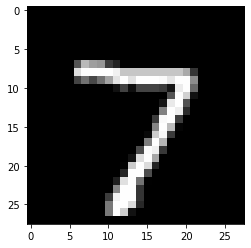

In [58]:
import matplotlib.pyplot as plt
data = test_data[0][0]
plt.imshow(data.reshape((28, 28)), cmap='gray')

In [59]:
test_data[0][1]

7

In [64]:
model.eval()
with torch.no_grad():
  x = data.unsqueeze(0).to(device)
  logits = model(x)
  pred = torch.softmax(logits, 1).squeeze().cpu()

In [61]:
pred

tensor([4.2510e-06, 3.3585e-09, 1.5709e-05, 5.1008e-04, 1.0449e-06, 9.5421e-06,
        4.1619e-09, 9.9897e-01, 9.4623e-06, 4.8093e-04])

<BarContainer object of 10 artists>

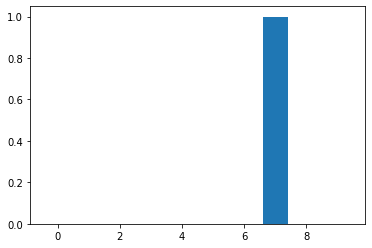

In [62]:
plt.bar(range(10), pred)